In [2]:
import os
import pathlib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
path = !pwd
root_path = pathlib.Path(path[0]).parent

df = pd.read_csv(f'{root_path}/data/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [7]:
df.isnull().values.any()

False

## Correlation

Computing correlation between mean features and between var features

In [8]:
mean_feat = [x for x in df.columns if x.endswith('mean')]
var_feat = [ x for x in df.columns if  x.endswith('var')]

mean_corr = df[mean_feat].corr()
var_corr = df[var_feat].corr()

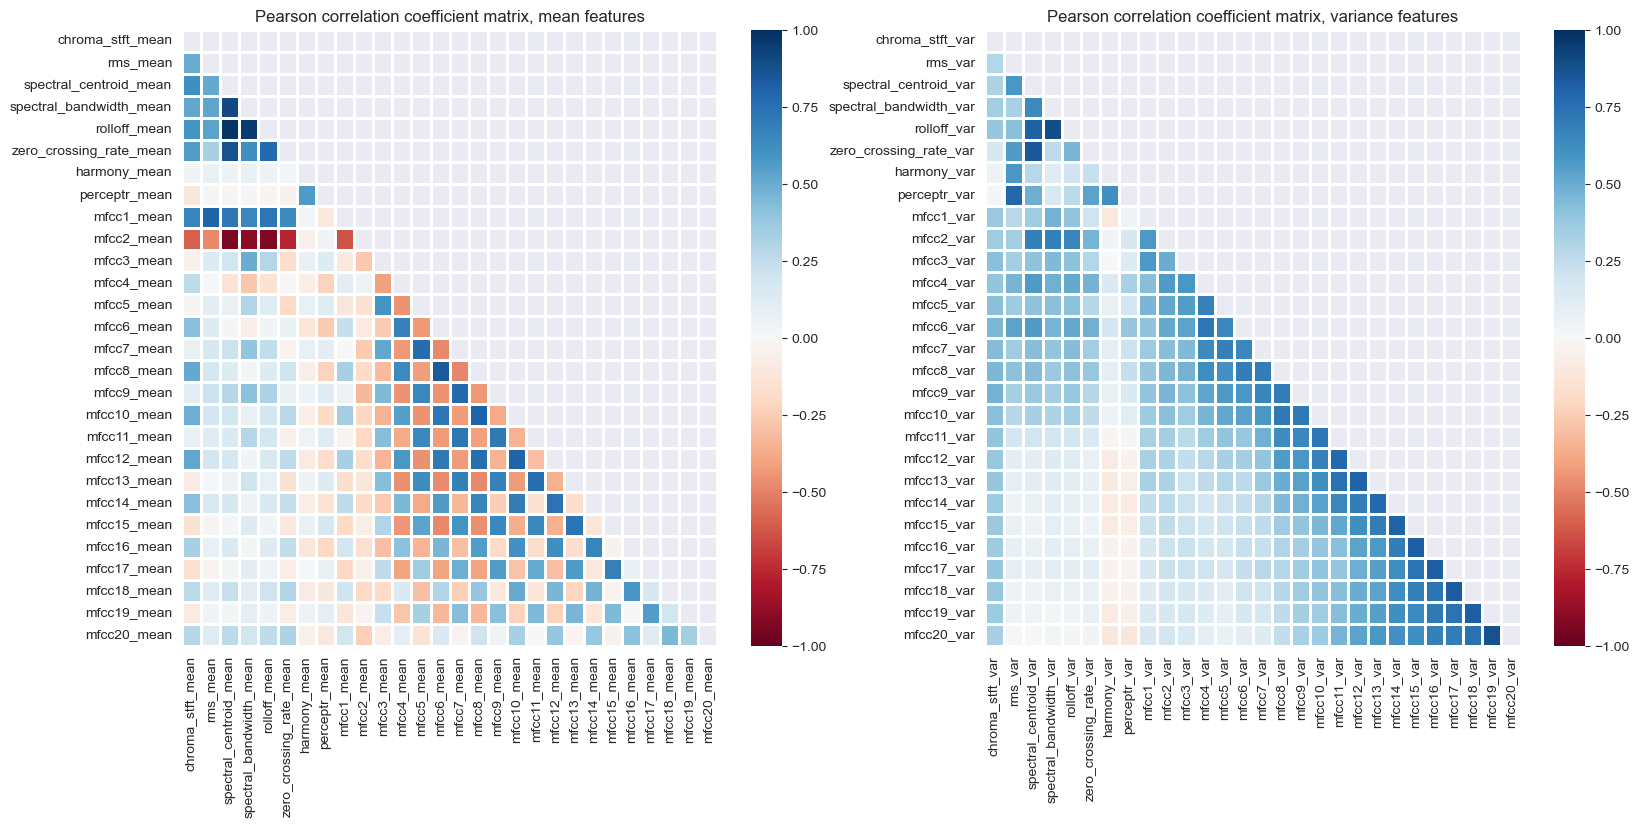

In [9]:
triu = np.triu(np.ones_like(mean_corr))

fig, ax = plt.subplots(1,2, figsize=(19, 8))

sns.heatmap(mean_corr, ax=ax[0], cmap='RdBu', center=0, linewidths=2, mask=triu, vmin=-1, vmax=1)
ax[0].set_title("Pearson correlation coefficient matrix, mean features")

sns.heatmap(var_corr, ax=ax[1], cmap='RdBu', center=0, linewidths=2, mask=triu, vmin=-1, vmax=1)
ax[1].set_title("Pearson correlation coefficient matrix, variance features")

plt.show()

## Distribution of features and outliers

In [10]:
mean_num = len(mean_feat)
mean_num

28

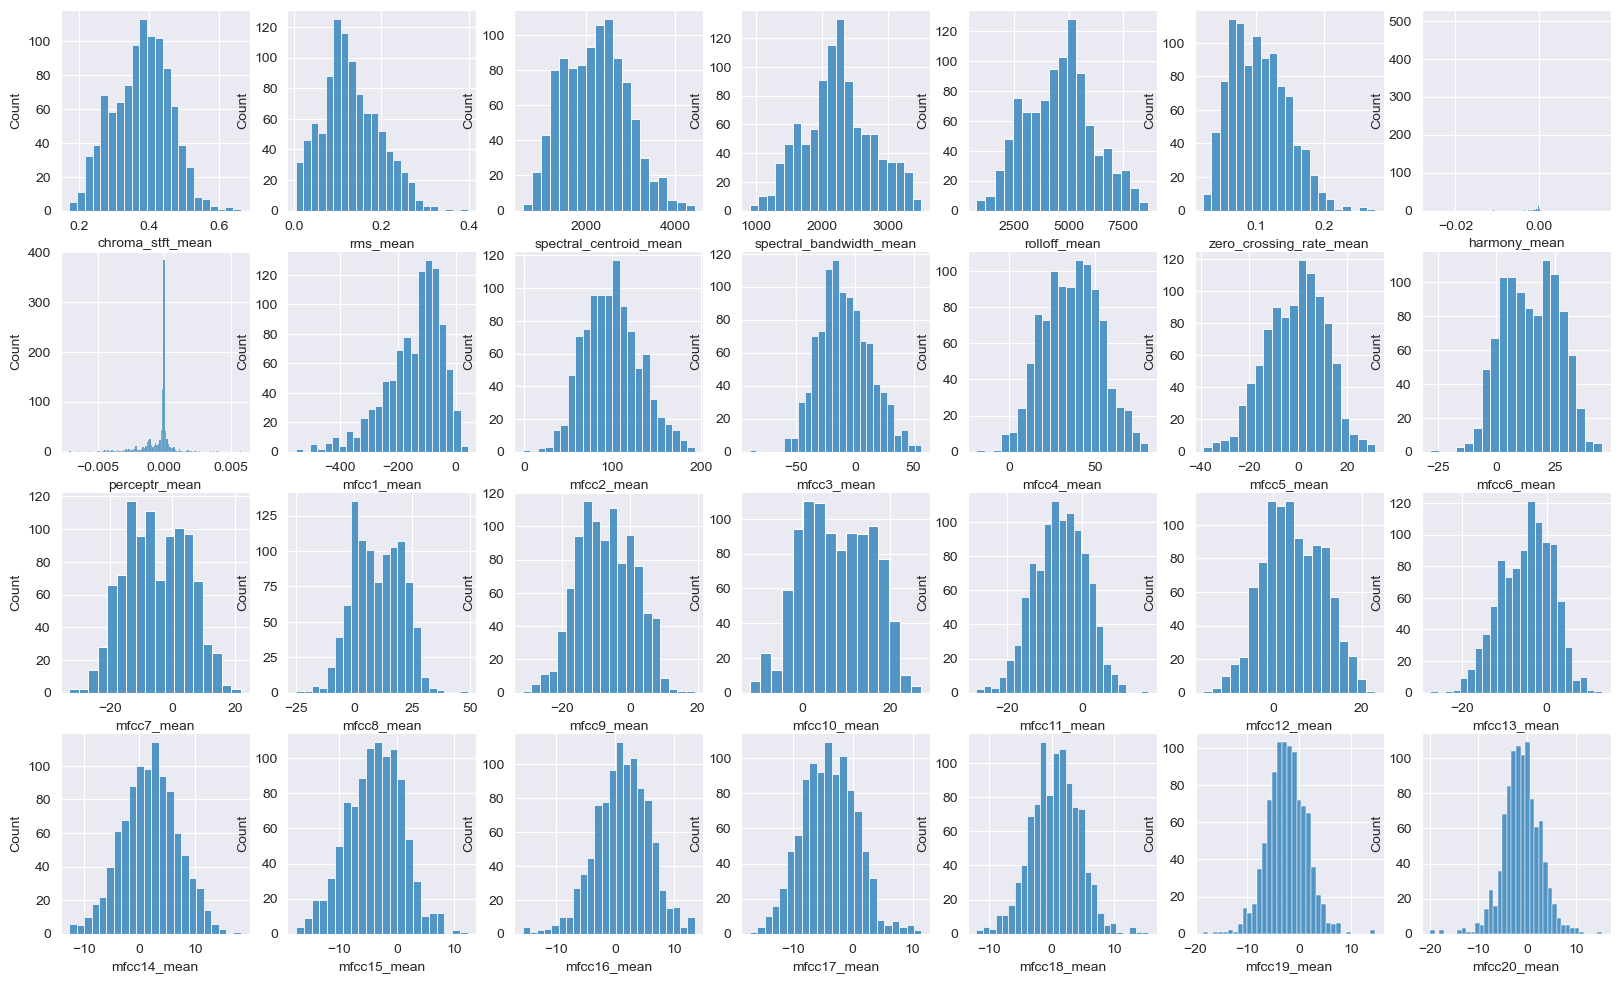

In [11]:
fig, axs = plt.subplots(4, 7, figsize=(20, 12))

for i in range(mean_num):
    sns.histplot(df[mean_feat[i]], ax=axs[i//7, i%7])

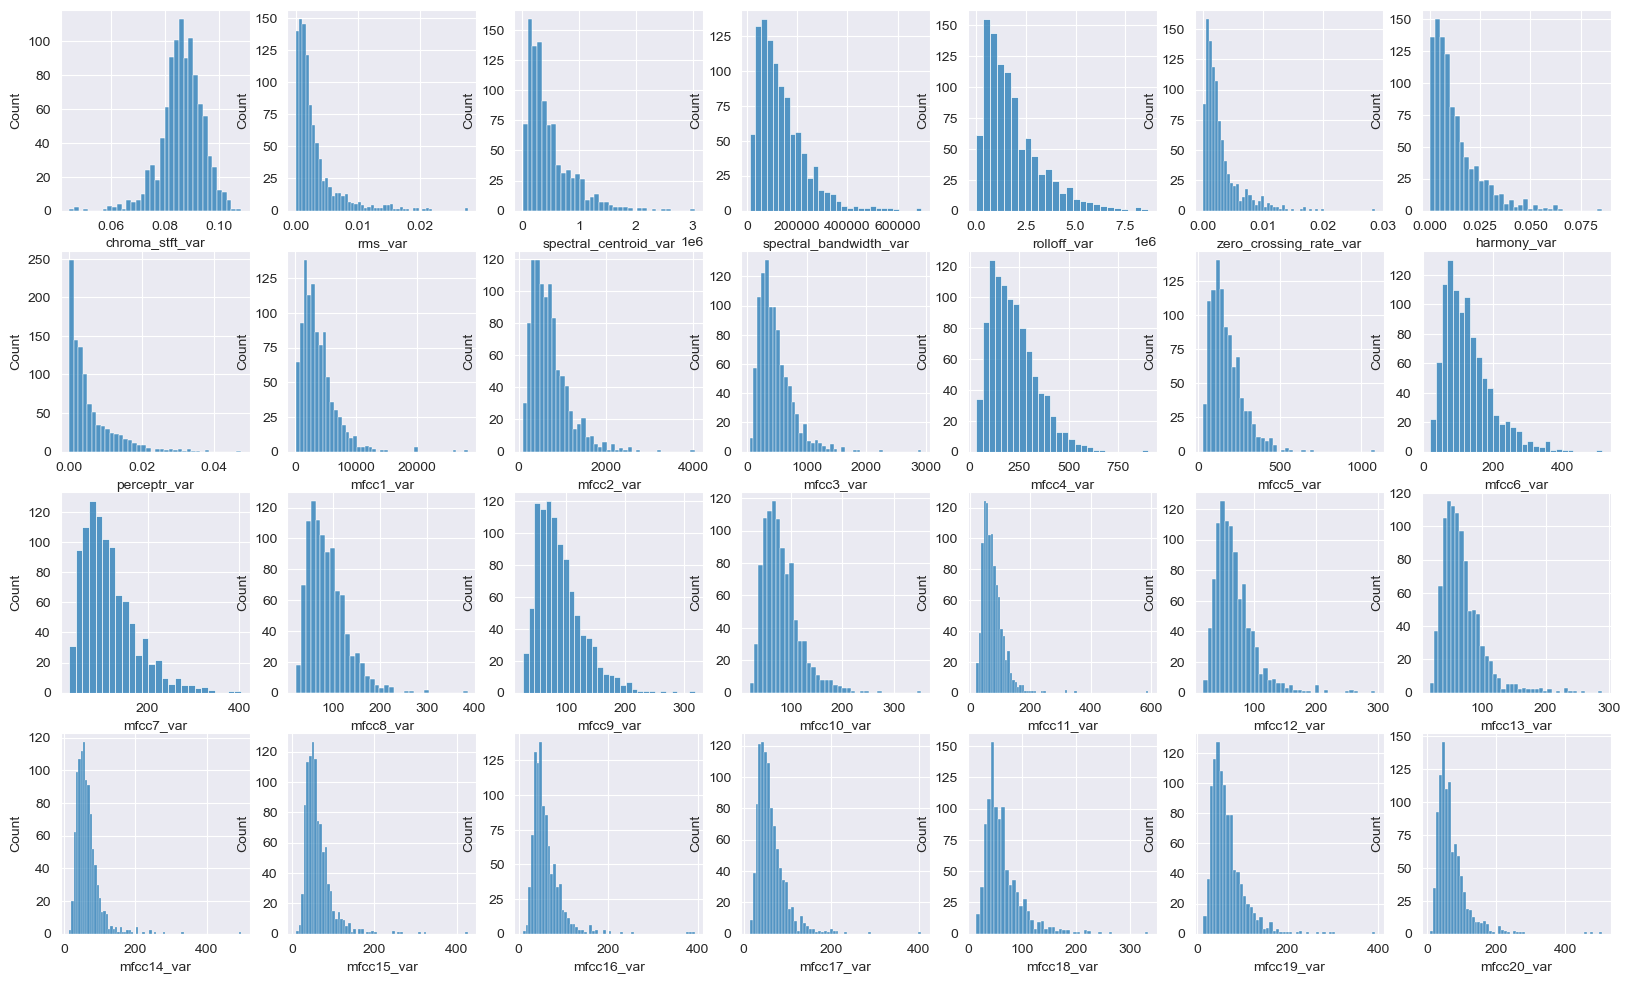

In [12]:
var_num = len(var_feat)

fig, axs = plt.subplots(4, 7, figsize=(20, 12))

for i in range(var_num):
    sns.histplot(df[var_feat[i]], ax=axs[i//7, i%7])

## Distribution by genre

Text(0.5, 1.0, 'chroma_stft_var: distribution by genre')

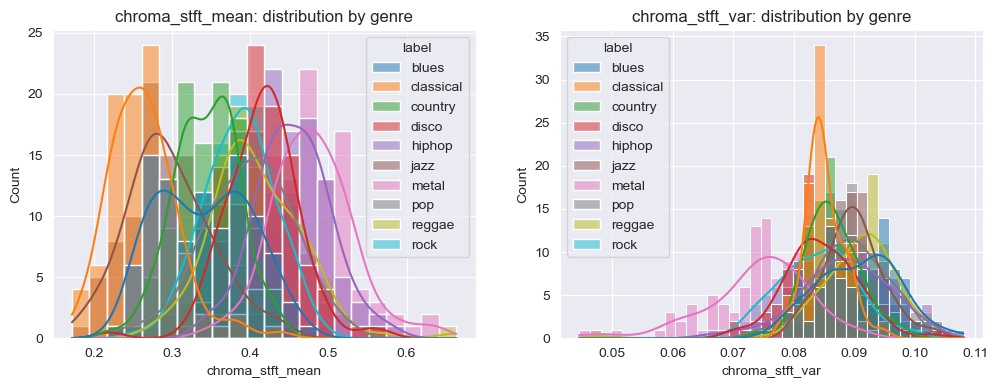

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

sns.histplot(df, hue='label', x='chroma_stft_mean', kde=True, ax=ax[0])
ax[0].set_title('chroma_stft_mean: distribution by genre')
sns.histplot(df, hue='label', x='chroma_stft_var', kde=True, ax=ax[1])
ax[1].set_title('chroma_stft_var: distribution by genre')


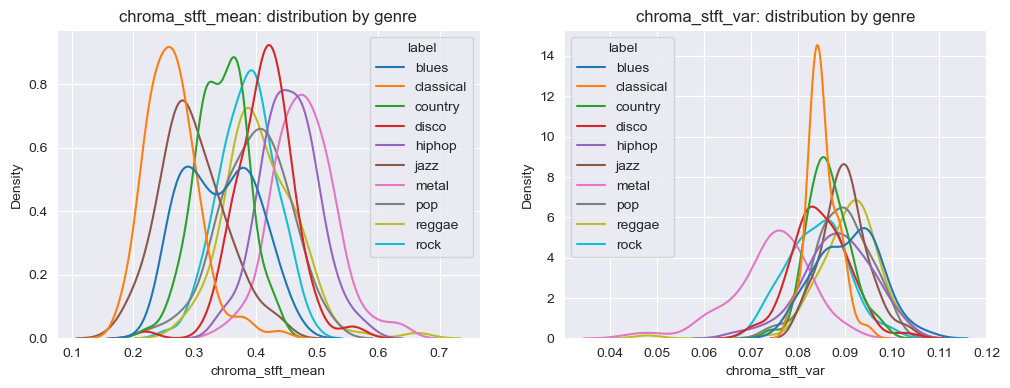

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

sns.kdeplot(df, x='chroma_stft_mean', hue='label', ax=ax[0])
ax[0].set_title('chroma_stft_mean: distribution by genre')
sns.kdeplot(df, x='chroma_stft_var', hue='label', ax=ax[1])
ax[1].set_title('chroma_stft_var: distribution by genre')


plt.show()

## Baseline model selection

Selecting some models to work with

In [6]:
from src.supervised_learning.supervised_learning import load_train_val

X_train, X_val, y_train, y_val = load_train_val(f'{root_path}/data/train_test_val_split')

In [22]:
from src.supervised_learning.evaluate_models import evaluate_models

l = ['model', 'accuracy', 'precision', 'recall']
metrics = evaluate_models(f'{root_path}/data/train_test_val_split', print_results=False)

res = pd.DataFrame(np.array([[x for x in metrics.keys()],
        [round(val['accuracy'], 2) for val in metrics.values()],
        [round(val['precision'], 2) for val in metrics.values()],
        [round(val['recall'], 2) for val in metrics.values()]]).T, columns=l)
pd.set_option('display.precision',3)
res = res.sort_values(by='accuracy')
res

,model,accuracy,precision,recall
10,gaussian mixture,0.15,0.11,0.15
0,decision_tree,0.51,0.53,0.5
9,naive_bayes,0.59,0.58,0.58
6,knn_12,0.6,0.63,0.59
4,knn_6,0.65,0.64,0.64
5,knn_9,0.65,0.67,0.65
3,knn_3,0.66,0.71,0.66
7,random_forest_gini,0.71,0.72,0.7
8,random_forest_entropy,0.73,0.75,0.73
1,logistic_regression,0.76,0.75,0.76


In [23]:
with open(f'{root_path}/logs/highest_score/ml_techniques_df.pickle', 'wb') as f:
    pickle.dump(res, f)

## Hyperparameters selection

In [16]:
from src.supervised_learning.parameter_search import search_logit_hyperparams, search_svm_hyperparams

In [14]:
# might take a bit to run
log_mod, log_acc = search_logit_hyperparams()

best accuracy: 0.7331661491919433, best model hyperparams: {'solver': 'saga', 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'C': 0.3593813663804626, 'max_iter': 8000}


best accuracy: 0.716427091833532, best model hyperparams: {'solver': 'saga', 'penalty': 'l1', 'C': 0.3593813663804626, 'max_iter': 8000}

In [15]:
svm_mod, svm_acc = search_svm_hyperparams()

print(f'logit: {log_acc}, svm: {svm_acc}')

best accuracy: 0.7635379348777963, best model hyperparams: {'C': 2.782559402207126, 'kernel': 'rbf'}
logit: 0.7331661491919433, svm: 0.7635379348777963


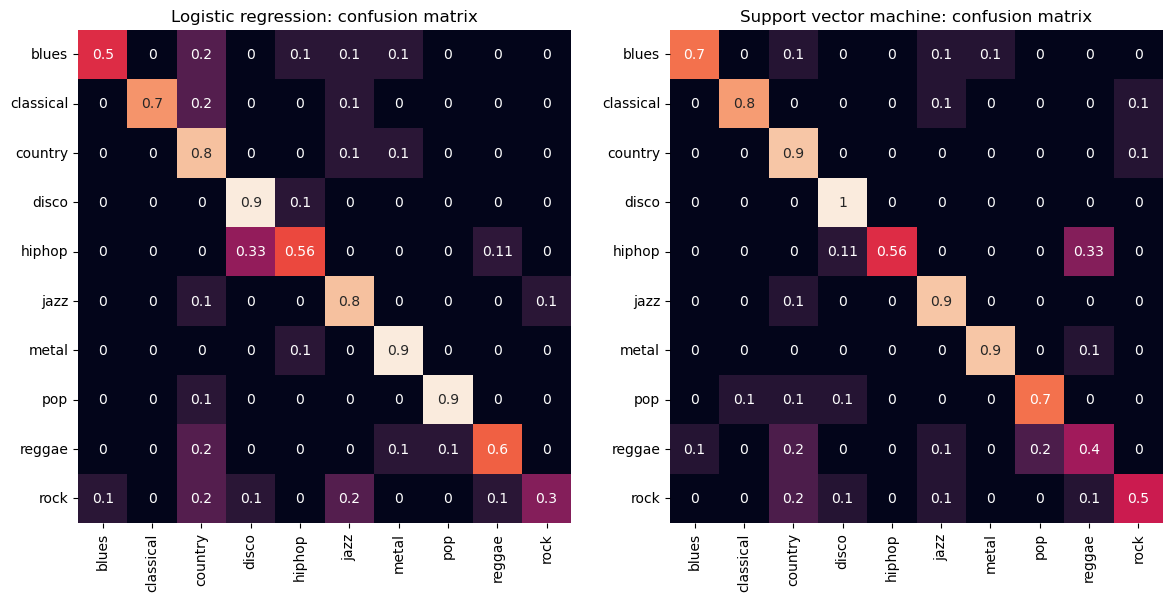

LOGISTIC REGRESSION - accuracy: 0.697, precision: 0.736, recall: 0.696
SVM - accuracy: 0.737, precision: 0.762, recall: 0.736


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from src.supervised_learning.supervised_learning import compute_metrics

logit = LogisticRegression(**log_mod).fit(X_train, y_train)
svm = SVC(**svm_mod).fit(X_train, y_train)

y_pred_logit = logit.predict(X_val)
y_pred_svm = svm.predict(X_val)

log_metrics = compute_metrics(y_val, y_pred_logit, f'{root_path}/data/train_test_val_split')
svm_metrics = compute_metrics(y_val, y_pred_svm, f'{root_path}/data/train_test_val_split')

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.heatmap(log_metrics['confusion_matrix'], ax=ax[0], square=True, annot=True, cbar=False)
ax[0].set_title("Logistic regression: confusion matrix")
sns.heatmap(svm_metrics['confusion_matrix'], ax=ax[1], square=True, annot=True, cbar=False)
ax[1].set_title("Support vector machine: confusion matrix")

plt.show()

log_acc = log_metrics['accuracy']
log_prec = log_metrics['precision']
log_rec = log_metrics['recall']

svm_acc = svm_metrics['accuracy']
svm_prec = svm_metrics['precision']
svm_rec = svm_metrics['recall']
print(f'LOGISTIC REGRESSION - accuracy: {log_acc:.3f}, precision: {log_prec:.3f}, recall: {log_rec:.3f}')
print(f'SVM - accuracy: {svm_acc:.3f}, precision: {svm_prec:.3f}, recall: {svm_rec:.3f}')

## Feature_3_sec and testing on test set

In [10]:
df3 = pd.read_csv(f'{root_path}/data/features_3_sec.csv')
df3.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [15]:
# null values
df3.isnull().values.any()

# missing data points
df3['fname'] = df3['filename'].apply(lambda x: ''.join(x.rsplit('.', 2)[:1] + ['.wav']))
print(df3.groupby('fname')['fname'].count().sort_values(ascending=True))


fname
country.00004.wav       9
classical.00051.wav     9
country.00003.wav       9
country.00007.wav       9
hiphop.00031.wav        9
                       ..
disco.00042.wav        10
disco.00043.wav        10
disco.00044.wav        10
disco.00031.wav        10
rock.00099.wav         10
Name: fname, Length: 1000, dtype: int64


In [24]:
from src.supervised_learning.features_3_sec_compare import fit_models

metrics_bef_aggr, metrics_3, metrics_30 = fit_models()
acc_before_aggregation, acc_3, acc_30 = metrics_bef_aggr['accuracy'], metrics_3['accuracy'], metrics_30['accuracy']
prec_before_aggregation, prec_3, prec_30 = metrics_bef_aggr['precision'], metrics_3['precision'], metrics_30['precision']
rec_before_aggregation, rec_3, rec_30 = metrics_bef_aggr['recall'], metrics_3['recall'], metrics_30['recall']


print(f'3-sec original: accuracy: {acc_before_aggregation:.3f}, precision: {prec_before_aggregation:.3f}, recall: {rec_before_aggregation:.3f}')
print(f'3-sec aggregated:  accuracy: {acc_3:.3f}, precision: {prec_3:.3f}, recall: {rec_3:.3f}')
print(f'30-sec: accuracy: {acc_30:.3f}, precision: {prec_30:.3f}, recall: {rec_30:.3f}')


3-sec original: accuracy: 0.690, precision: 0.699, recall: 0.688
3-sec aggregated:  accuracy: 0.758, precision: 0.779, recall: 0.757
30-sec: accuracy: 0.697, precision: 0.732, recall: 0.696


3-sec original: accuracy: 0.690, precision: 0.699, recall: 0.688
3-sec aggregated:  accuracy: 0.758, precision: 0.779, recall: 0.757
30-sec: accuracy: 0.697, precision: 0.732, recall: 0.696


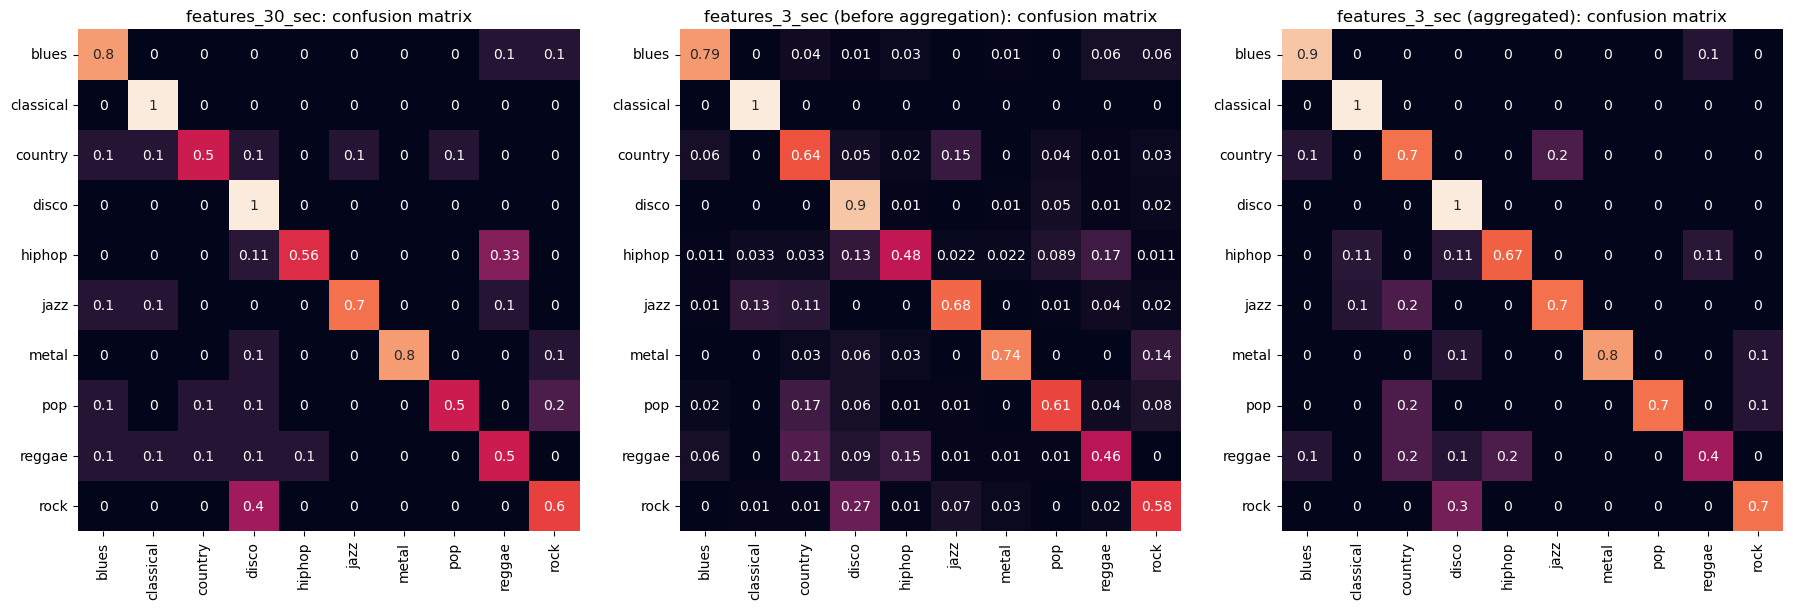

In [25]:
cm_3_orig, cm_3, cm_30 = metrics_bef_aggr['confusion_matrix'], metrics_3['confusion_matrix'], metrics_30['confusion_matrix']

fig, ax = plt.subplots(1, 3, figsize=(22, 7))

sns.heatmap(cm_3, ax=ax[2], annot=True, square=True, cbar=False)
ax[2].set_title('features_3_sec (aggregated): confusion matrix')
sns.heatmap(cm_30, ax=ax[0], annot=True, square=True, cbar=False)
ax[0].set_title('features_30_sec: confusion matrix')
sns.heatmap(cm_3_orig, ax=ax[1], annot=True, square=True, cbar=False)
ax[1].set_title('features_3_sec (before aggregation): confusion matrix')

print(f'3-sec original: accuracy: {acc_before_aggregation:.3f}, precision: {prec_before_aggregation:.3f}, recall: {rec_before_aggregation:.3f}')
print(f'3-sec aggregated:  accuracy: {acc_3:.3f}, precision: {prec_3:.3f}, recall: {rec_3:.3f}')
print(f'30-sec: accuracy: {acc_30:.3f}, precision: {prec_30:.3f}, recall: {rec_30:.3f}')


In [26]:
with open(f'{root_path}/logs/highest_score/svm_cm.pickle', 'wb') as f:
    pickle.dump(cm_3, f)

### Computing accuracy by class

In [19]:
# accuracy_by_class = pd.DataFrame(np.array([np.diag(cm_30) / np.sum(cm_30, axis=1), 
#                                           np.diag(cm_3) / np.sum(cm_3, axis=1), cm_30.columns]).T, 
#                                     columns=['30-sec', '3-sec', 'genre', 'df'])
accuracy_by_class_30 = pd.DataFrame(np.array([np.diag(cm_30) / np.sum(cm_30, axis=1), cm_30.columns, 
                                                                  np.full_like(a=cm_30.columns, fill_value='30-sec')]).T,
                                                       columns=['accuracy', 'genre', 'df'])
accuracy_by_class_3 = pd.DataFrame(np.array([np.diag(cm_3) / np.sum(cm_3, axis=1), cm_3.columns,
                                                                  np.full_like(a=cm_3.columns, fill_value='3-sec')]).T,
                                                       columns=['accuracy', 'genre', 'df'])

accuracy_by_class = pd.concat([accuracy_by_class_3, accuracy_by_class_30])
                                               

Text(0.5, 1.0, 'Accuracy by genre - 3sec (aggregated)')

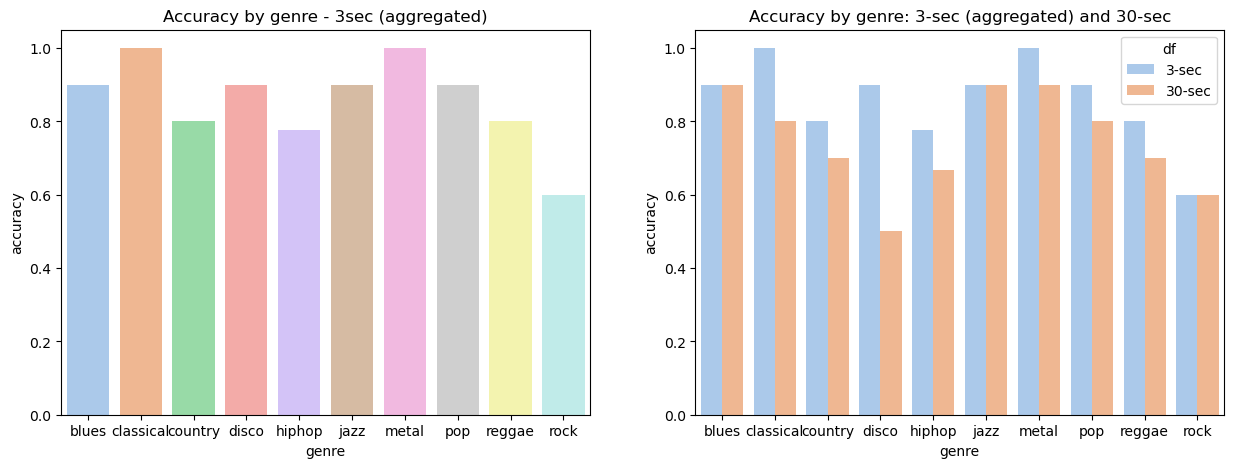

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(accuracy_by_class, x='genre', y='accuracy', hue='df', palette=sns.color_palette('pastel'), ax=ax[1])
ax[1].set_title("Accuracy by genre: 3-sec (aggregated) and 30-sec")
sns.barplot(accuracy_by_class_3, x='genre', y='accuracy', palette=sns.color_palette('pastel'), ax=ax[0])
ax[0].set_title("Accuracy by genre - 3sec (aggregated)")


In [ ]:
with open('logs/highest_score/avm_acc_by_genre.pickle', 'rb') as f:
    df = pickle.load(f)

In [27]:
accuracy_by_class

,accuracy,genre,df
0,0.9,blues,3-sec
1,1.0,classical,3-sec
2,0.8,country,3-sec
3,0.9,disco,3-sec
4,0.778,hiphop,3-sec
5,0.9,jazz,3-sec
6,1.0,metal,3-sec
7,0.9,pop,3-sec
8,0.8,reggae,3-sec
9,0.6,rock,3-sec
